In [164]:
import numpy as np 
import pandas as pd 

# Load train and test

In [165]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [166]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [167]:
_ = train.pop('id')

In [168]:
y = train.pop('Premium Amount')
X = train

In [169]:
data_processing_tr = X
data_processing_tr['y'] = y

# Data Cleaning

## Null Visualization

In [170]:
import missingno as msno
from matplotlib import pyplot as plt

In [171]:
X.columns[X.isnull().any()==False]

Index(['Gender', 'Education Level', 'Location', 'Policy Type',
       'Policy Start Date', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'y'],
      dtype='object')

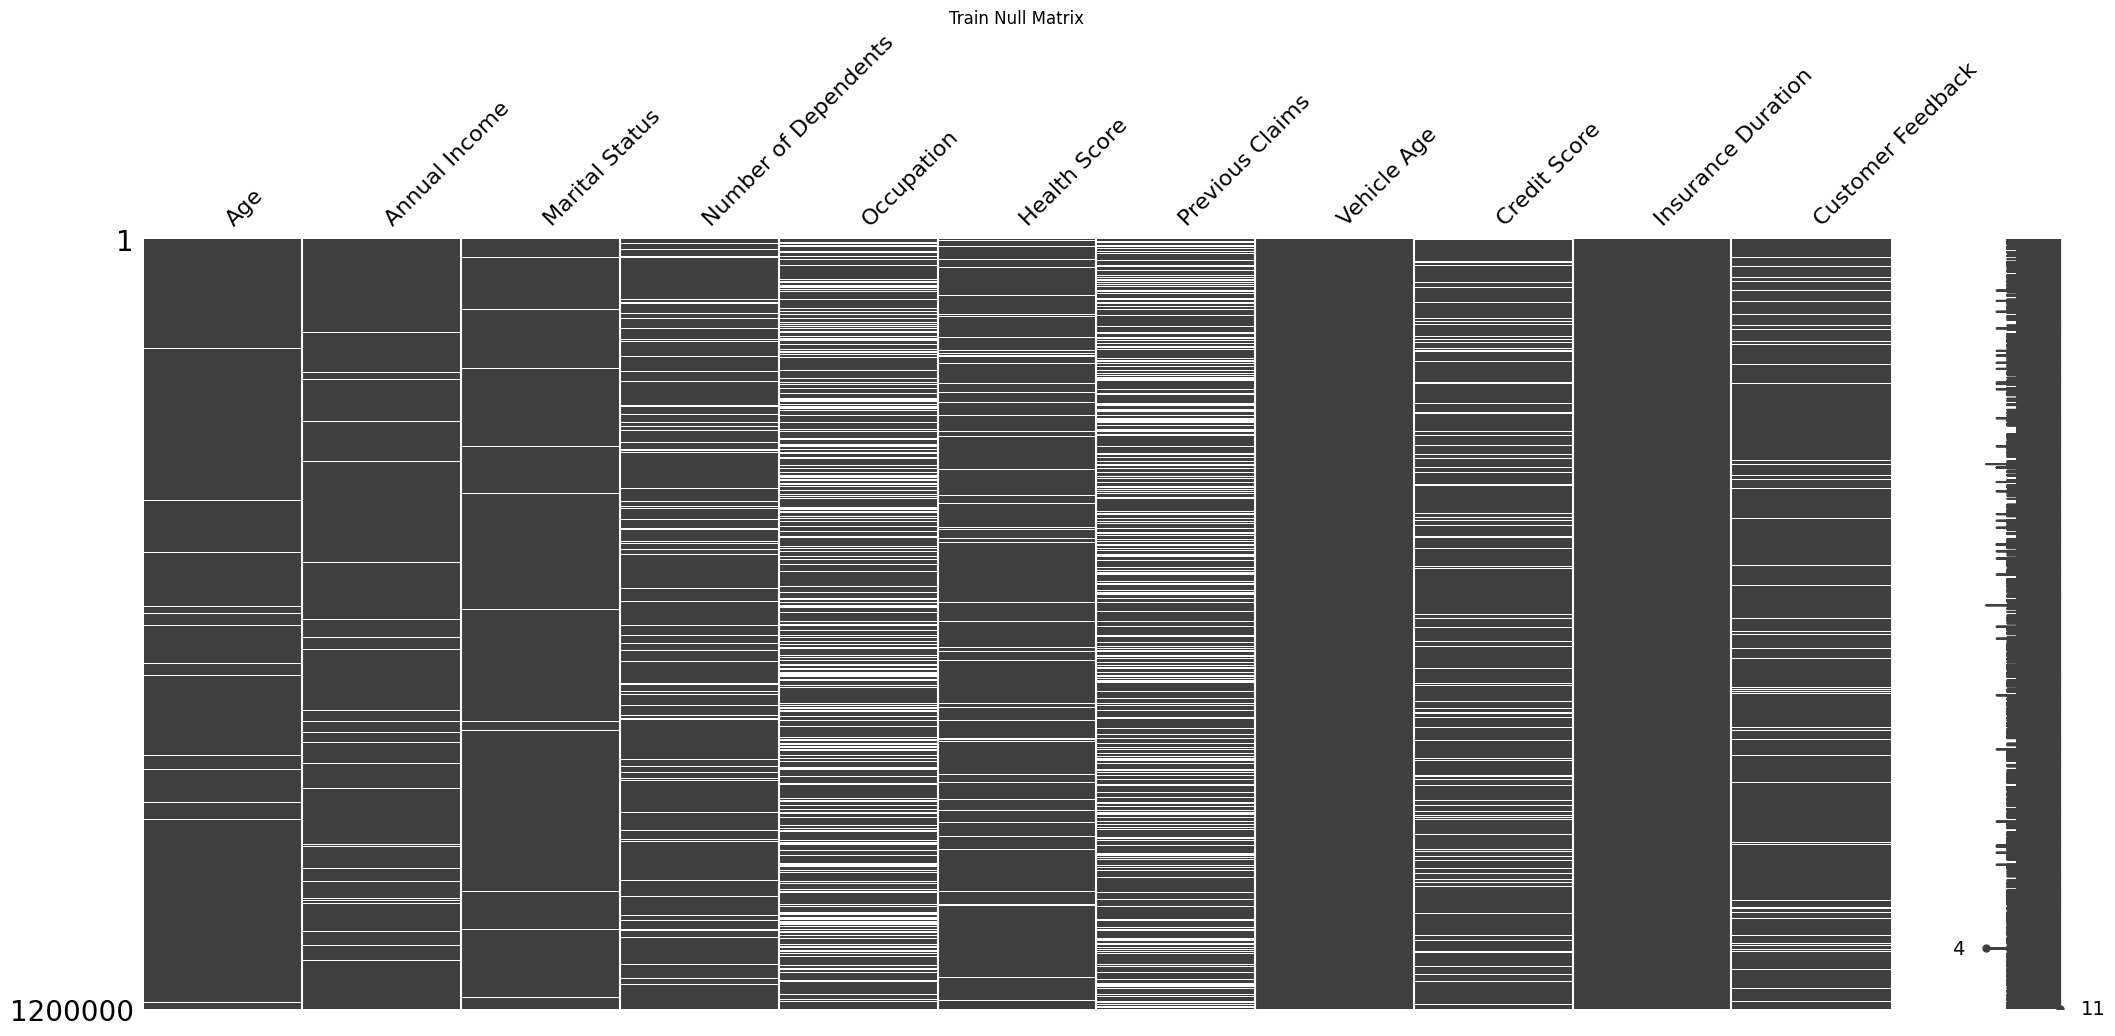

In [172]:
msno.matrix(X[X.columns[X.isnull().any()]])
_ = plt.title('Train Null Matrix')

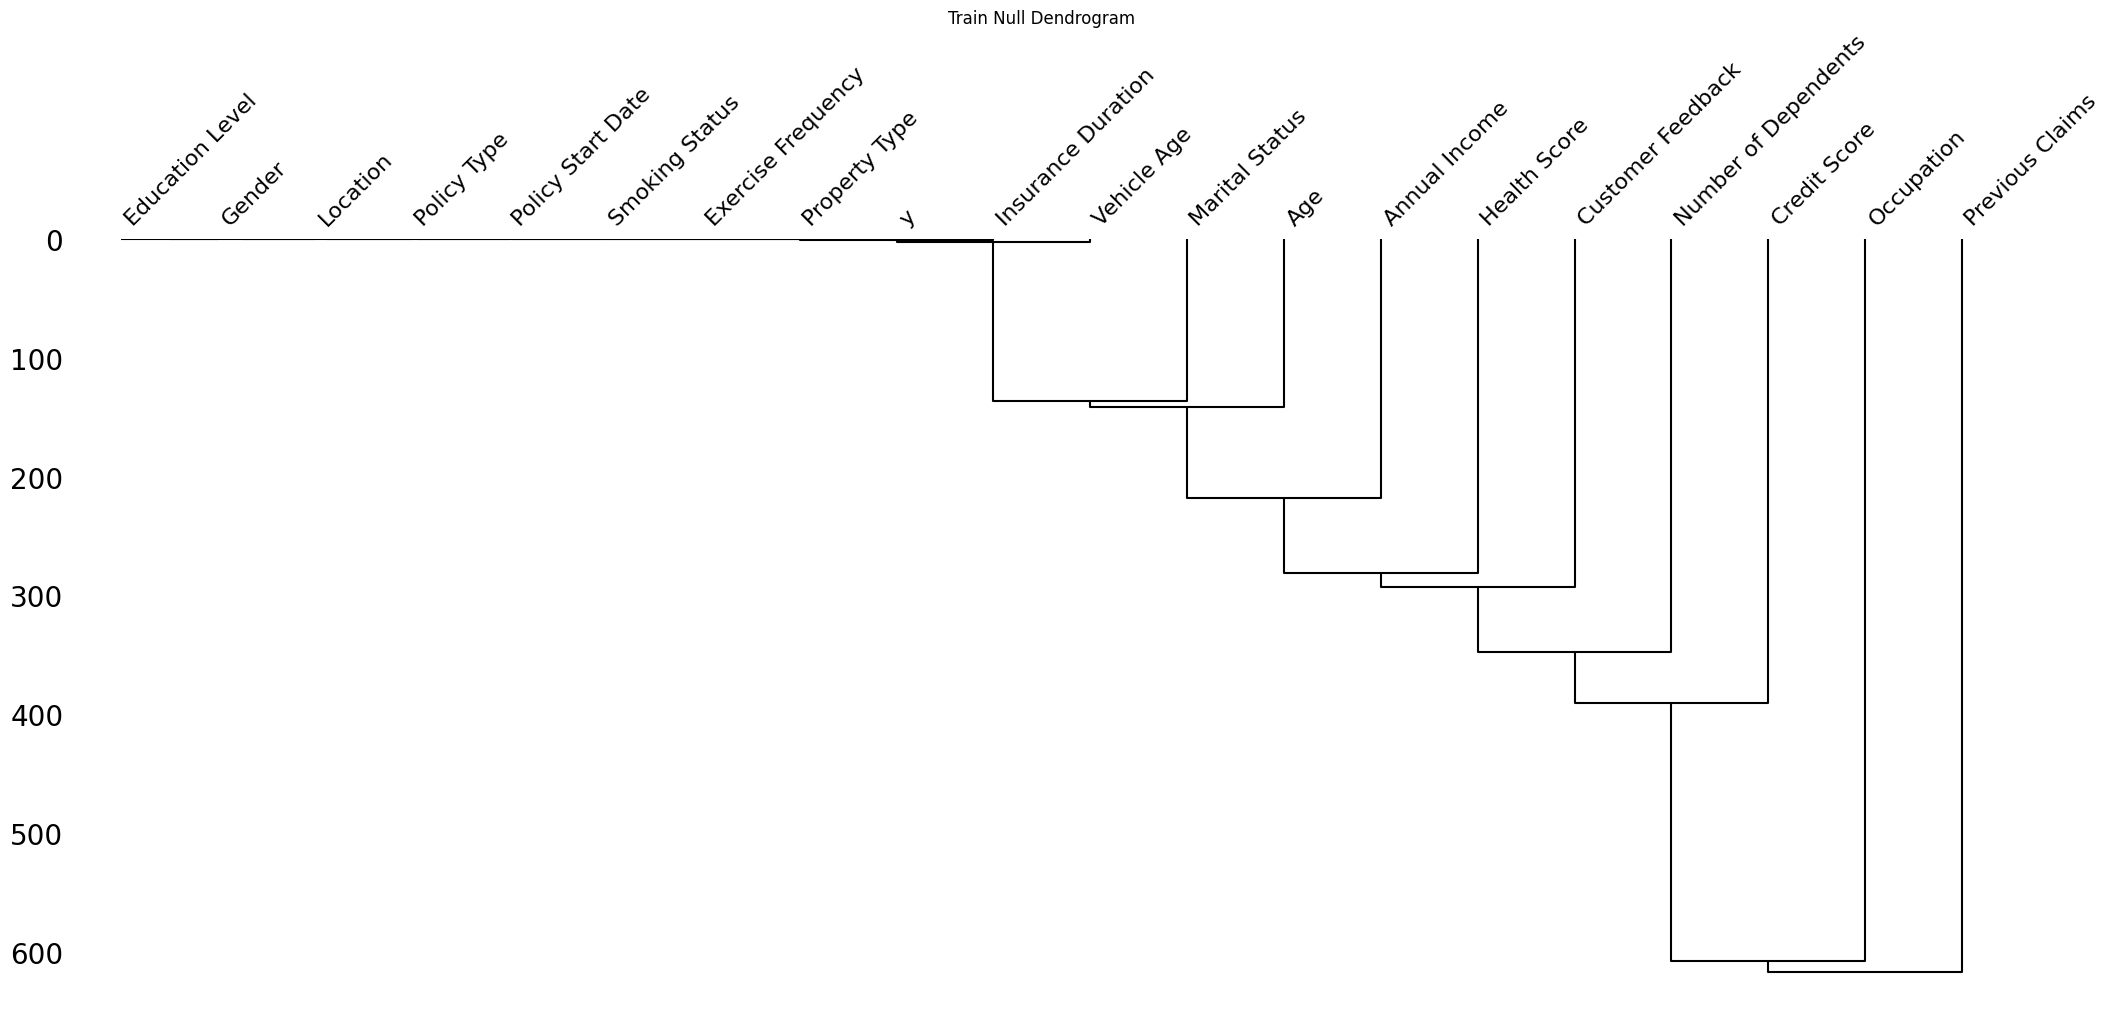

In [173]:
msno.dendrogram(X)
_ = plt.title('Train Null Dendrogram')

It seemse like Vehicle age and insurance duration are closely related. Shall look at these columns first. 

But before that, draw a dendrogram of test:

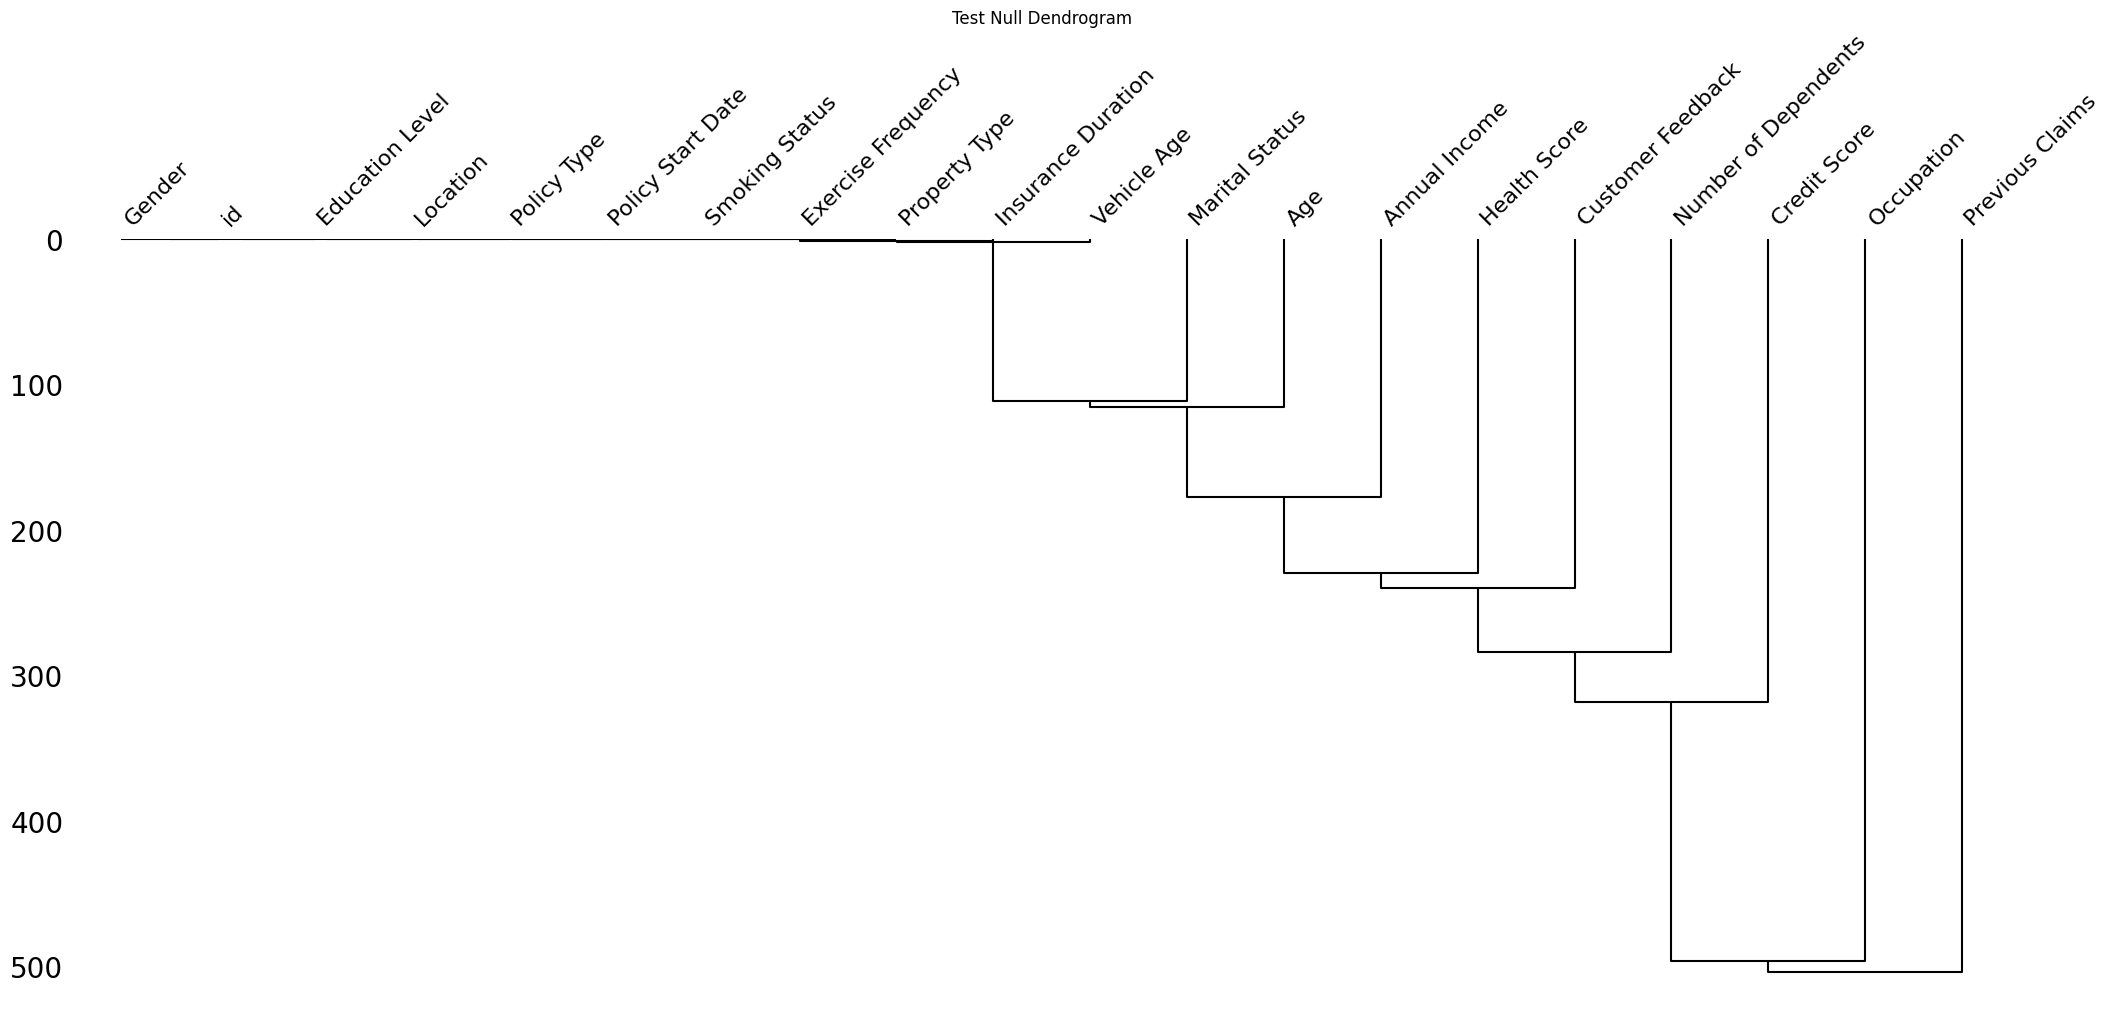

In [174]:
msno.dendrogram(test)
_ = plt.title('Test Null Dendrogram')

When I first try to clear nulls with Bayesian inference, the session ran out of memories. So I decided to look at other columns first

In [175]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

## Age

In [176]:
import math
age_fill = math.floor(data_processing_tr['Age'].mean())
X.Age = X.Age.fillna(age_fill)

In [177]:
age_fill = math.floor(test.Age.mean())
test.Age = test.Age.fillna(age_fill)

## Annual Income

In [178]:
X['Annual Income'].isnull().sum()

44949

In [179]:
# examine independence between annual income and target
from scipy.stats import kendalltau

kendalltau(data_processing_tr['Annual Income'].dropna(), data_processing_tr.loc[~data_processing_tr['Annual Income'].isnull(), 'y'])

SignificanceResult(statistic=-0.04236252602993693, pvalue=0.0)

As the p value is 0 and $\tau = -0.04$, we conclude that there's a weak but significant relation here. Thus, we should choose our null value for this column wisely.

Several features that may relate to this:
1. Gender? (sadly, it's true in real world)
2. Marital status?
3. Location?
4. Education Level?
5. Occupation?

### Annual Income vs Marital Status

In [180]:
from scipy.stats import ks_2samp, mannwhitneyu
single_income = data_processing_tr.loc[data_processing_tr['Marital Status']=='Single', 'Annual Income'].dropna()
married_income = data_processing_tr.loc[data_processing_tr['Marital Status']=='Married', 'Annual Income'].dropna()
divorce_income = data_processing_tr.loc[data_processing_tr['Marital Status']=='Divorced', 'Annual Income'].dropna()
secret_income = data_processing_tr.loc[data_processing_tr['Marital Status'].isnull(), 'Annual Income'].dropna()
nonsecret_income = data_processing_tr.loc[~data_processing_tr['Marital Status'].isnull(), 'Annual Income'].dropna()

_, pval = ks_2samp(single_income, married_income)
print('p val from kstest between incomes of single and married: {}'.format(pval))
_, pval = ks_2samp(married_income, divorce_income)
print('p val from kstest between incomes of married and divorced: {}'.format(pval))
_, pval = ks_2samp(divorce_income, single_income)
print('p val from kstest between incomes of single and divorced: {}'.format(pval))
_, pval = mannwhitneyu(single_income, secret_income)
print('p val from kstest between incomes of single and null marital status: {}'.format(pval))
_, pval = mannwhitneyu(married_income, secret_income)
print('p val from kstest between incomes of married and null marital status: {}'.format(pval))
_, pval = mannwhitneyu(divorce_income, secret_income)
print('p val from kstest between incomes of divorced and null marital status: {}'.format(pval))
_, pval = mannwhitneyu(secret_income, nonsecret_income)
print('p val from kstest between incomes of unknown and known marital status: {}'.format(pval))

p val from kstest between incomes of single and married: 0.11549438146907232
p val from kstest between incomes of married and divorced: 0.08741758468542771
p val from kstest between incomes of single and divorced: 0.6527680407681833
p val from kstest between incomes of single and null marital status: 2.233037625591361e-80
p val from kstest between incomes of married and null marital status: 7.558214141079957e-81
p val from kstest between incomes of divorced and null marital status: 8.082451259971593e-81
p val from kstest between incomes of unknown and known marital status: 4.447111068826509e-83


In [181]:
from scipy.stats import cramervonmises_2samp
print(cramervonmises_2samp(secret_income, nonsecret_income))
print(cramervonmises_2samp(secret_income, single_income))
print(cramervonmises_2samp(secret_income, married_income))
print(cramervonmises_2samp(secret_income, divorce_income))

CramerVonMisesResult(statistic=78.60071858340234, pvalue=2.827819756134886e-08)
CramerVonMisesResult(statistic=75.6309274485593, pvalue=1.6193449692281092e-08)
CramerVonMisesResult(statistic=77.09346609784188, pvalue=2.1421009854805106e-08)
CramerVonMisesResult(statistic=75.67182054800105, pvalue=1.632295054676547e-08)


It looks like unknown marital status has a different distribution of income than other status. should have plot this out: 

In [182]:
secretship = data_processing_tr[data_processing_tr['Marital Status'].isnull()]
secretship.describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,y
count,18529.000000,17573.000000,16657.000000,17623.000000,13222.000000,18529.000000,16253.000000,18529.000000,18529.000000
mean,41.093043,40273.786377,2.010926,25.939958,1.073514,9.616277,599.466191,5.002105,1217.871067
std,13.379156,38081.498250,1.424535,12.470474,1.024049,5.772856,148.384941,2.598314,904.286237
min,18.000000,17.000000,0.000000,2.068843,0.000000,0.000000,300.000000,1.000000,20.000000
25%,30.000000,6530.000000,1.000000,15.853765,0.000000,5.000000,480.000000,3.000000,571.000000
50%,41.000000,28574.000000,2.000000,25.084666,1.000000,10.000000,600.000000,5.000000,1001.000000
75%,53.000000,62735.000000,3.000000,35.505129,2.000000,15.000000,727.000000,7.000000,1659.000000
max,64.000000,149992.000000,4.000000,55.961187,7.000000,19.000000,849.000000,9.000000,4980.000000


In [183]:
nonsecretship = data_processing_tr[~data_processing_tr['Marital Status'].isnull()]

cramervonmises_2samp(secretship.y, nonsecretship.y)

CramerVonMisesResult(statistic=43.06235839321016, pvalue=5.582157958095024e-09)

<Axes: xlabel='y', ylabel='Density'>

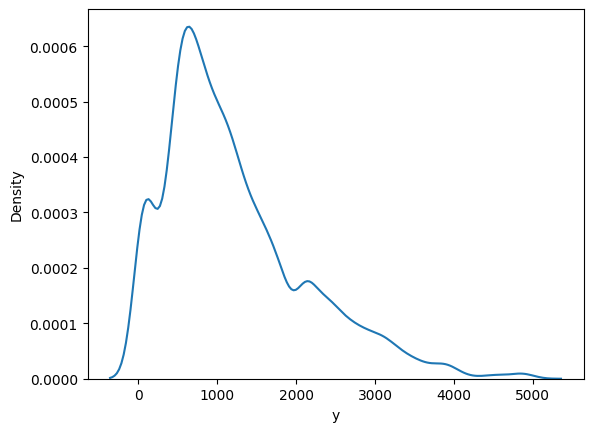

In [184]:
sns.kdeplot(secretship.y)

<Axes: xlabel='y', ylabel='Density'>

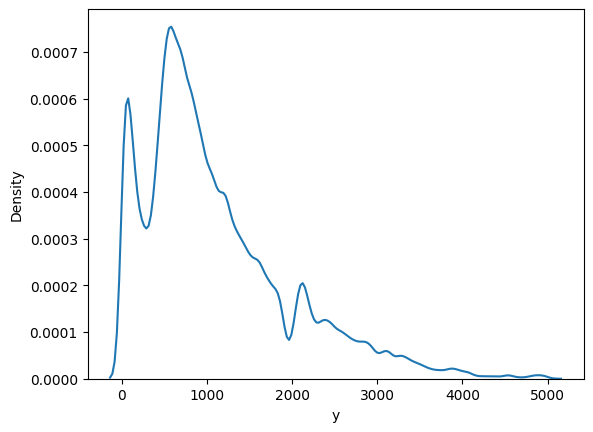

In [185]:
sns.kdeplot(nonsecretship.y)

next up: is there any difference in distributions of target variable between un-null marital status?

In [186]:
single_y = data_processing_tr.loc[data_processing_tr['Marital Status']=='Single', 'y']
married_y = data_processing_tr.loc[data_processing_tr['Marital Status']=='Married', 'y']
divorce_y = data_processing_tr.loc[data_processing_tr['Marital Status']=='Divorced', 'y']

_, pval1 = ks_2samp(single_y, married_y)
_, pval2 = ks_2samp(married_y, divorce_y)
_, pval3 = ks_2samp(divorce_y, single_y)
print(pval1)
print(pval2)
print(pval3)

0.650928436226483
0.5825681208624114
0.2064811835167979


So we can confirm that nulls here should be treated as a new category

In [187]:
X['Marital Status'].fillna('Other', inplace=True)
test['Marital Status'].fillna('Other', inplace=True)

<Axes: xlabel='Annual Income', ylabel='Density'>

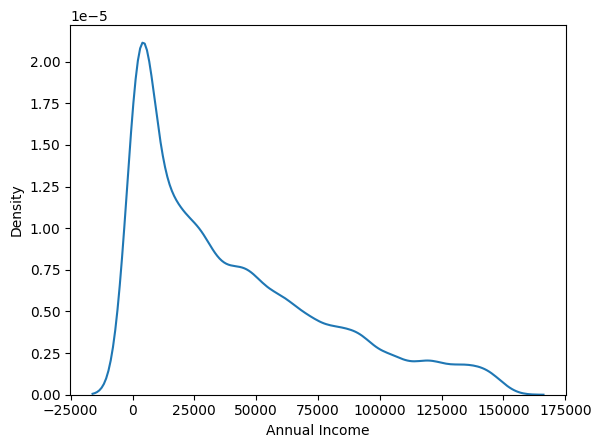

In [188]:
sns.kdeplot(X.loc[X['Marital Status']=='Other', 'Annual Income'])

<Axes: xlabel='Annual Income', ylabel='Density'>

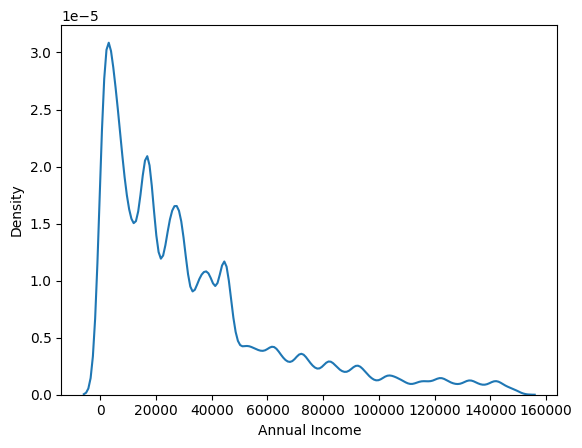

In [189]:
sns.kdeplot(nonsecretship['Annual Income'])

In [190]:
null_income_i = X[X['Annual Income'].isnull()].index.tolist()
for i in null_income_i:
    m_status = X.loc[i, 'Marital Status']
    if m_status=='Other':
        fill = np.random.choice(secret_income)
    else:
        fill  = np.random.choice(nonsecret_income)
    X.loc[i, 'Annual Income'] = fill  

<Axes: xlabel='Annual Income', ylabel='Density'>

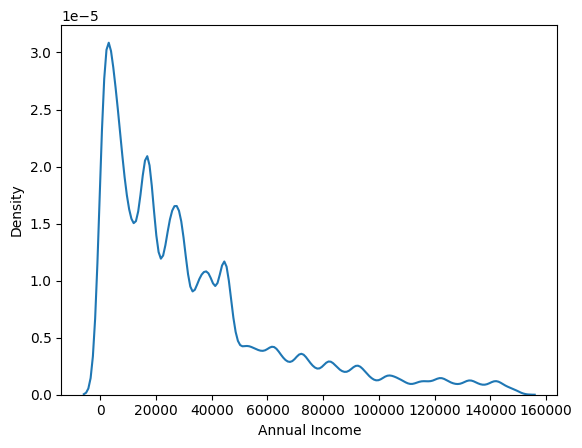

In [191]:
sns.kdeplot(nonsecretship['Annual Income'])

<Axes: xlabel='Annual Income', ylabel='Density'>

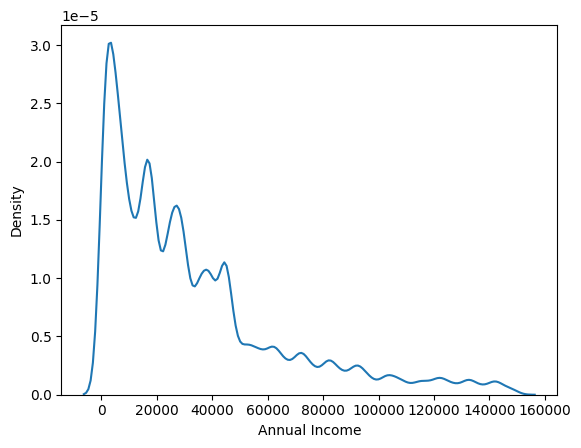

In [192]:
secret_income_test = test.loc[test['Marital Status']=='Other', 'Annual Income'].dropna()
nonsecret_income_test =  test.loc[test['Marital Status']!='Other', 'Annual Income'].dropna()

null_income_i = test[test['Annual Income'].isnull()].index.tolist()
for i in null_income_i:
    m_status = test.loc[i, 'Marital Status']
    if m_status=='Other':
        fill = np.random.choice(secret_income_test)
    else:
        fill  = np.random.choice(nonsecret_income_test)
    test.loc[i, 'Annual Income'] = fill  
sns.kdeplot(test['Annual Income'])

In [193]:
X['Annual Income'].isnull().sum()

0

## Number of Dependants

<Axes: ylabel='Density'>

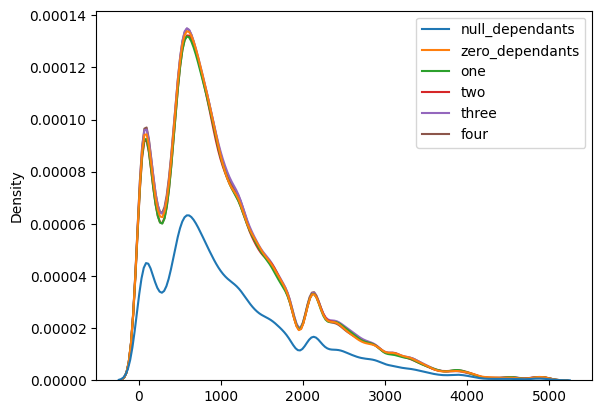

In [194]:
null_dependants = X[X['Number of Dependents'].isnull()]
zero_dependants = X[X['Number of Dependents']==0]
one = X[X['Number of Dependents']==1]
two = X[X['Number of Dependents']==2]
three = X[X['Number of Dependents']==3]
four = X[X['Number of Dependents']==4]

income_dependants = pd.DataFrame({
    'null_dependants': null_dependants['y'],
    'zero_dependants': zero_dependants['y'],
    'one': one['y'],
    'two': two['y'],
    'three': three['y'],
    'four': four['y']
})
sns.kdeplot(income_dependants)

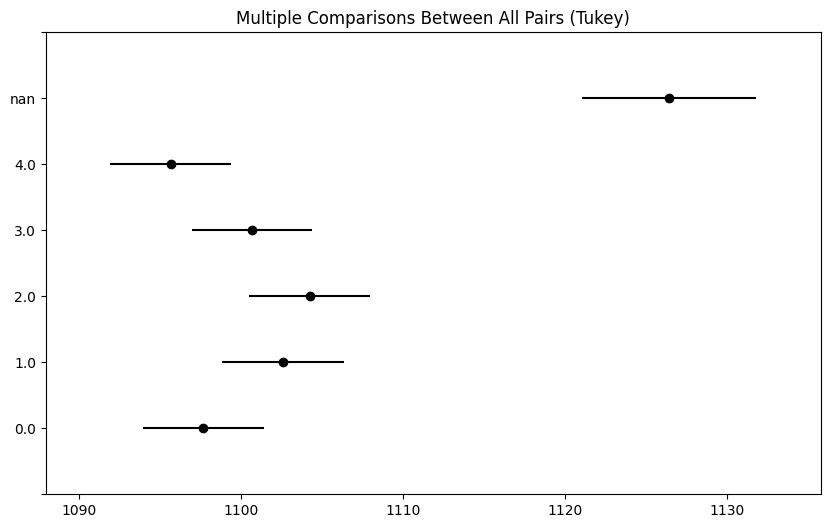

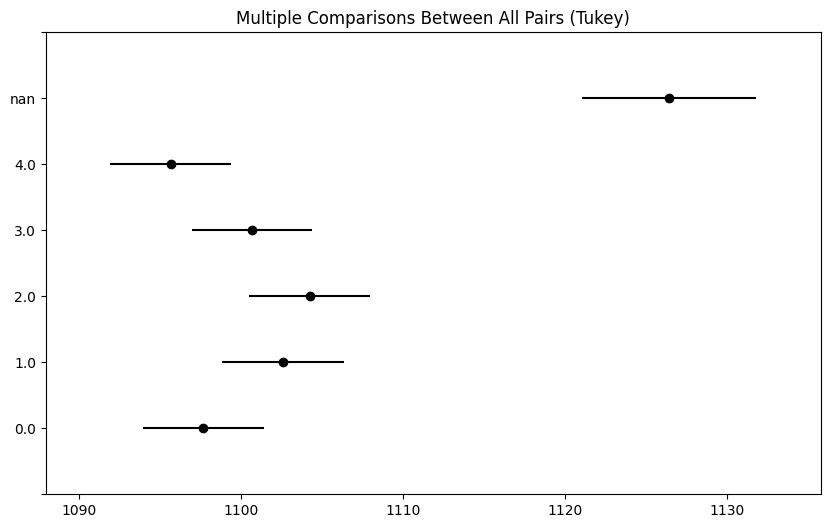

In [195]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

result = pairwise_tukeyhsd(endog=X['y'], groups=X['Number of Dependents'], alpha=0.05)
result.plot_simultaneous()

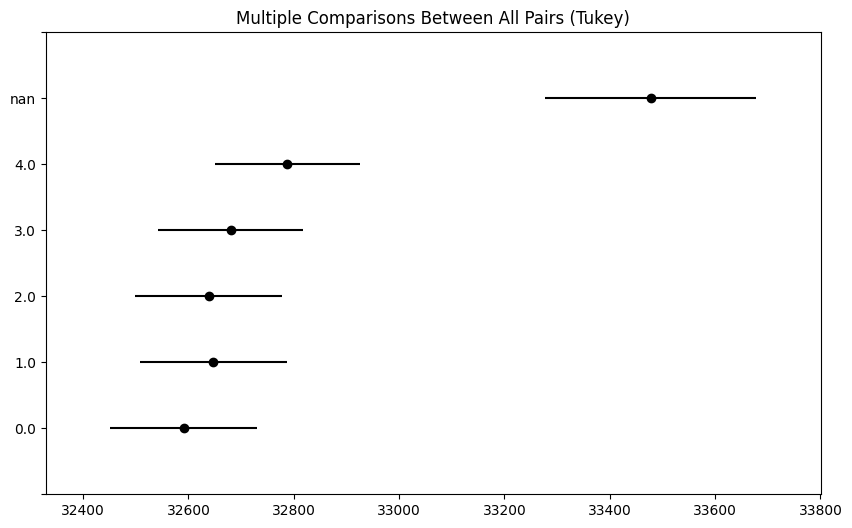

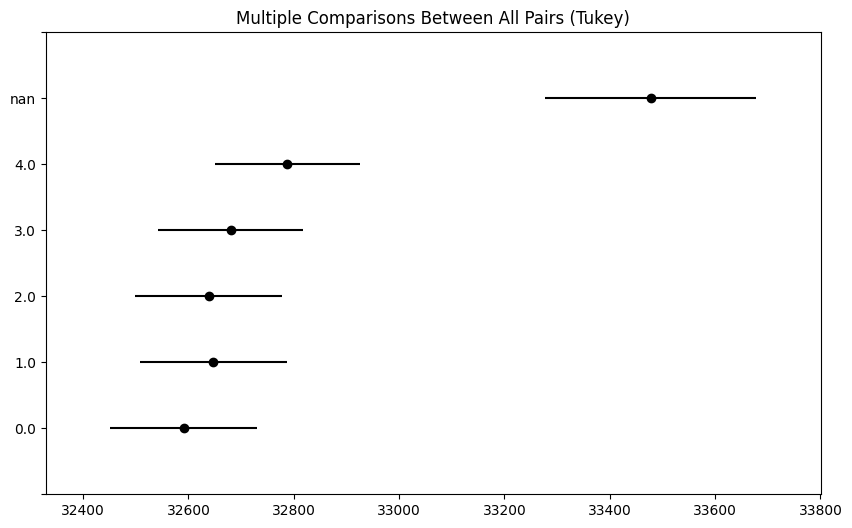

In [196]:
result = pairwise_tukeyhsd(endog=X['Annual Income'], groups=X['Number of Dependents'], alpha=0.05)
result.plot_simultaneous()

It's clear that null values in this column has a different distribution for target from other groups. Thus, this column should be turned into categorical.

In [197]:
X['Number of Dependents'].fillna('Other', inplace=True)
X['Number of Dependents'] = X['Number of Dependents'].astype('category')
X['Number of Dependents'].isnull().sum()

0

In [198]:
test['Number of Dependents'].fillna('Other', inplace=True)
test['Number of Dependents'] = test['Number of Dependents'].astype('category')
test['Number of Dependents'].isnull().sum()

0

## Occupation

In [199]:
data_processing_tr['Occupation'].unique()

array(['Self-Employed', nan, 'Employed', 'Unemployed'], dtype=object)

<Axes: ylabel='Density'>

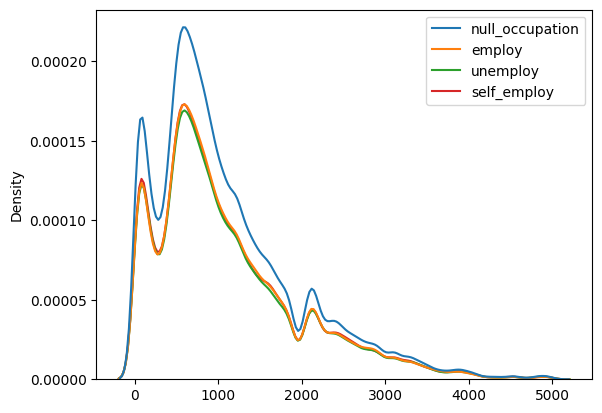

In [200]:
null_occupation = data_processing_tr[data_processing_tr['Occupation'].isnull()]
employ_y = data_processing_tr[data_processing_tr['Occupation']=='Employed']['y']
unemploy_y = data_processing_tr[data_processing_tr['Occupation']=='Unemployed']['y']
self_employ_y = data_processing_tr[data_processing_tr['Occupation']=='Self-Employed']['y']

y_job = pd.DataFrame(
    {
        'null_occupation': null_occupation.y,
        'employ': employ_y,
        'unemploy':unemploy_y,
        'self_employ': self_employ_y
        
    }
)
sns.kdeplot(y_job)

In [201]:
X['Occupation'].fillna('Other', inplace=True)

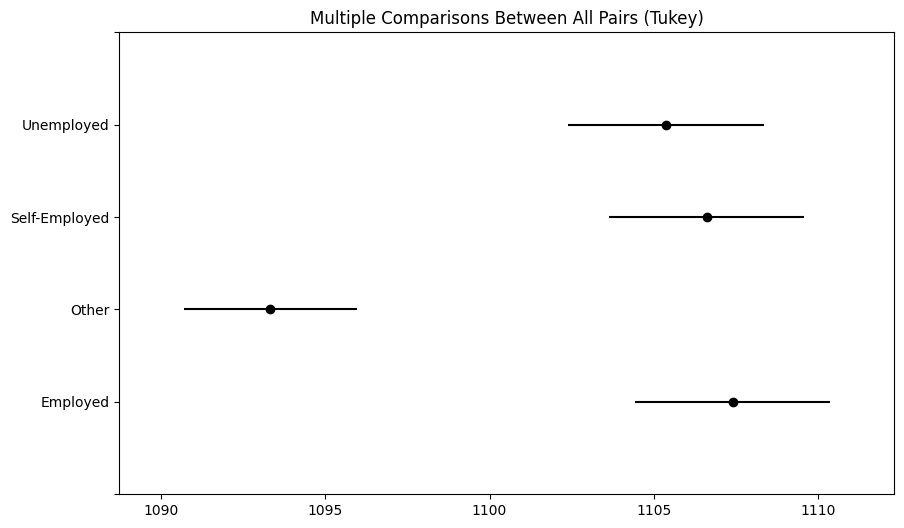

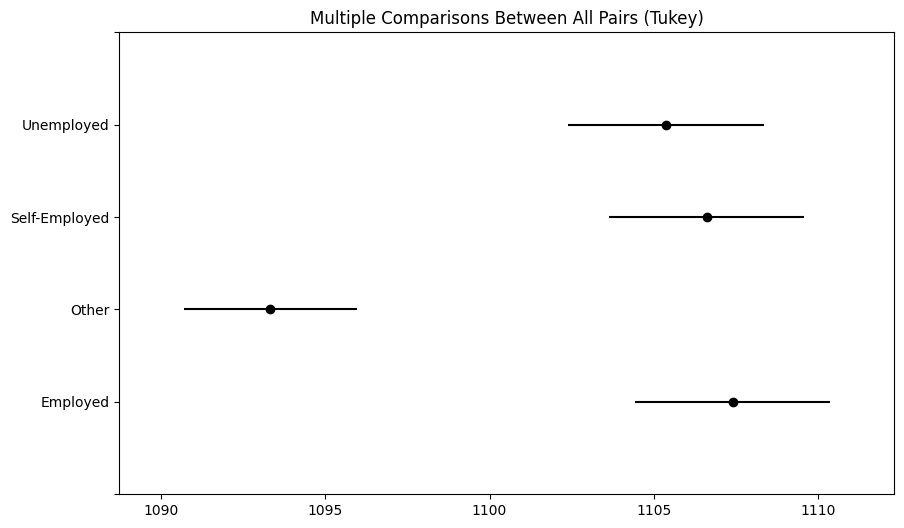

In [202]:
result = pairwise_tukeyhsd(endog=X['y'], groups=X['Occupation'], alpha=0.05)
result.plot_simultaneous()

In [203]:
test['Occupation'].fillna('Other', inplace=True)

X['Occupation'] = X['Occupation'].astype('category')
test['Occupation'] = test['Occupation'].astype('category')

## Health Score

In [204]:
health_distr = X.loc[~X['Health Score'].isnull(), 'Health Score']
X['Health Score'] = X['Health Score'].apply(lambda x: x if not np.isnan(x) else np.random.choice(health_distr))

In [205]:
test_health_distr = test.loc[~test['Health Score'].isnull(), 'Health Score']
test['Health Score'] = test['Health Score'].apply(lambda x: x if not np.isnan(x) else np.random.choice(test_health_distr))

## Previous Claims

In [206]:
null_claims = data_processing_tr.loc[data_processing_tr['Previous Claims'].isnull()]

In [207]:
X['Previous Claims'].fillna(0, inplace=True)
test['Previous Claims'].fillna(0, inplace=True)

## Credit Score 

<Axes: xlabel='Credit Score', ylabel='Density'>

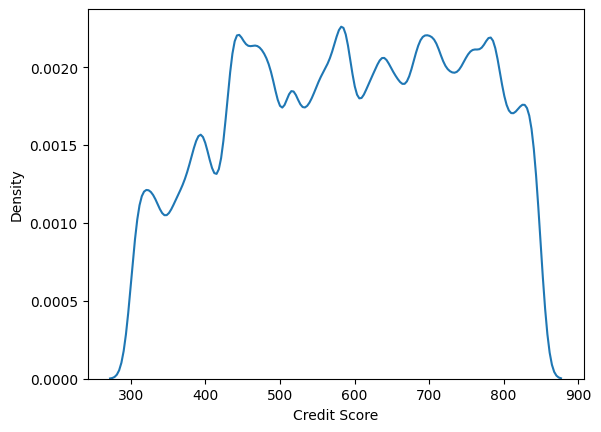

In [208]:
sns.kdeplot(X['Credit Score'])

In [209]:
credits = X.loc[~X['Credit Score'].isnull(), 'Credit Score']
X['Credit Score'] = X['Credit Score'].apply(lambda x: x if not np.isnan(x) else np.random.choice(credits))

In [210]:
test_credits = test.loc[~test['Credit Score'].isnull(), 'Credit Score']
test['Credit Score'] = test['Credit Score'].apply(lambda x: x if not np.isnan(x) else np.random.choice(test_credits))

## Insurance Duration

In [212]:
# According to the discussion post here: https://www.kaggle.com/competitions/playground-series-s4e12/discussion/552165
# This column isn't null by random so we have to keep it
X['Insurance Duration'].fillna(10, inplace=True)
test['Insurance Duration'].fillna(10, inplace=True)

## Vehicle Age

In [214]:
X['Vehicle Age'].isnull().sum()

6

In [215]:
test['Vehicle Age'].isnull().sum()

3

In [217]:
X['Vehicle Age'].fillna(0, inplace=True)
test['Vehicle Age'].fillna(0, inplace=True)

## Customer Feedback

In [218]:
X['Customer Feedback'].value_counts(dropna=False)

Customer Feedback
Average    377905
Poor       375518
Good       368753
NaN         77824
Name: count, dtype: int64

In [219]:
X['Customer Feedback'].fillna('Other', inplace=True)
test['Customer Feedback'].fillna('Other', inplace=True)

## Policy Start Date

I didn't think about looking into this column until I looked deeper into the data

In [226]:
X['Policy Start Date'] = pd.to_datetime(X['Policy Start Date'])

In [231]:
X['Policy Start Year'] = X['Policy Start Date'].apply(lambda x: x.year)

<Axes: xlabel='Month'>

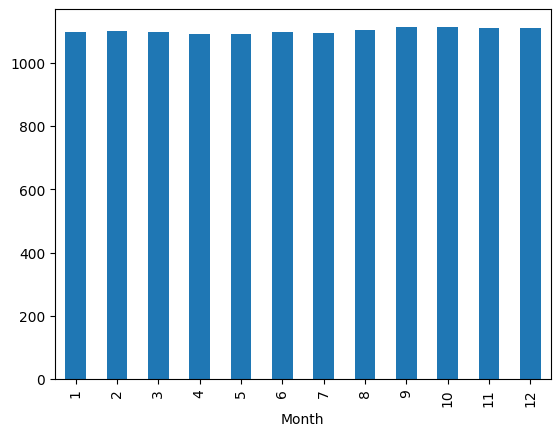

In [236]:
X['Month'] = X['Policy Start Date'].apply(lambda x: x.mont)

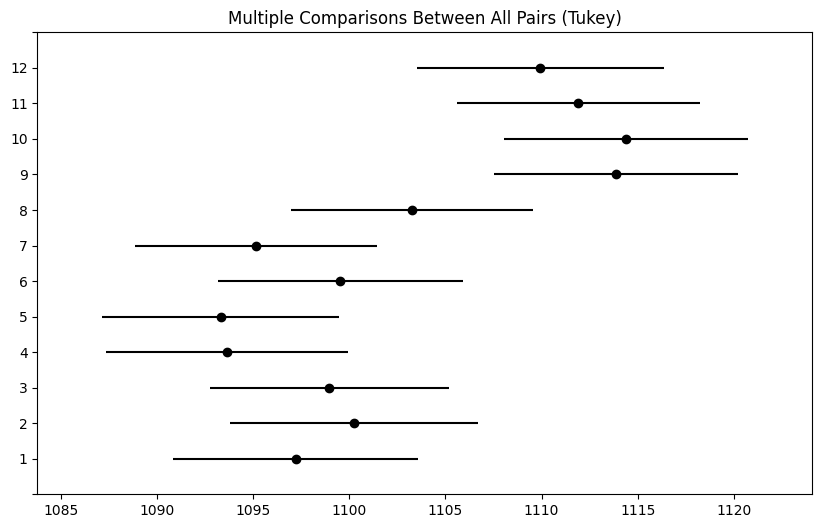

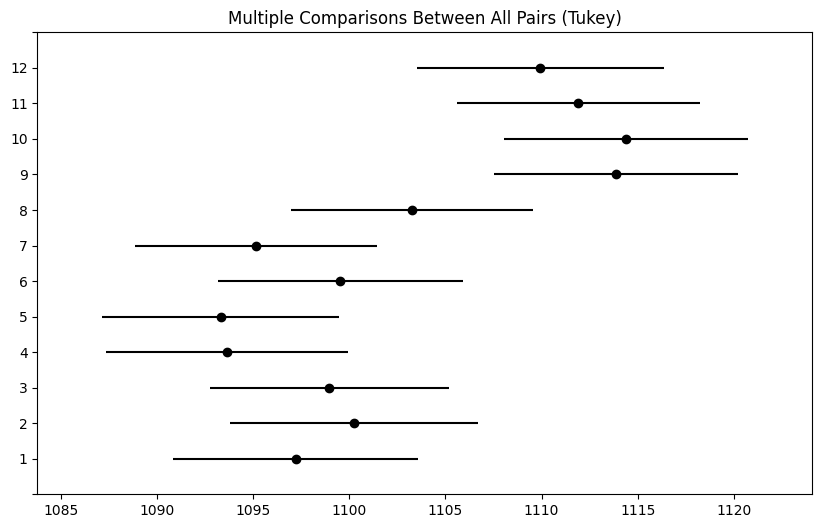

In [240]:
result = pairwise_tukeyhsd(endog=X['y'], groups=X['Month'], alpha=0.05)
result.plot_simultaneous()

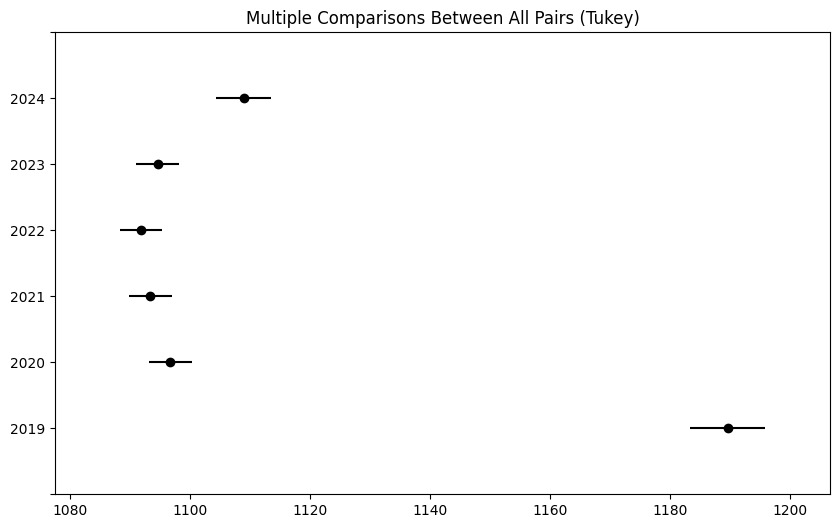

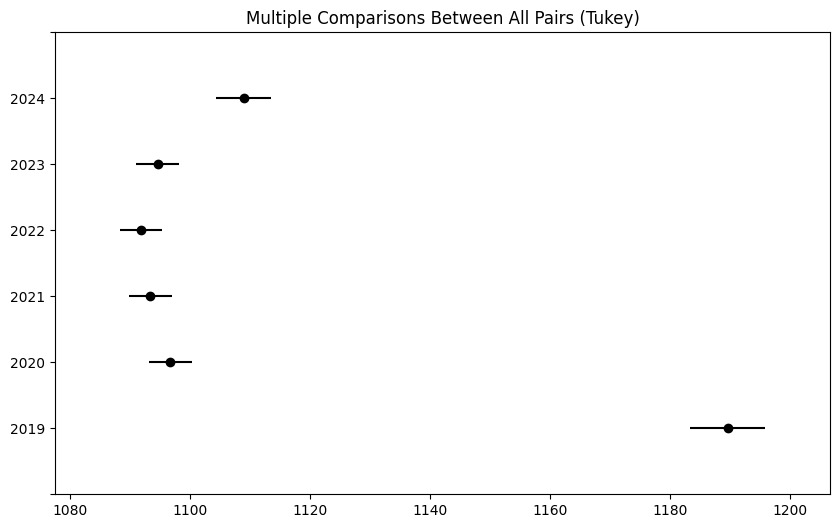

In [241]:
result = pairwise_tukeyhsd(endog=X['y'], groups=X['Policy Start Year'], alpha=0.05)
result.plot_simultaneous()

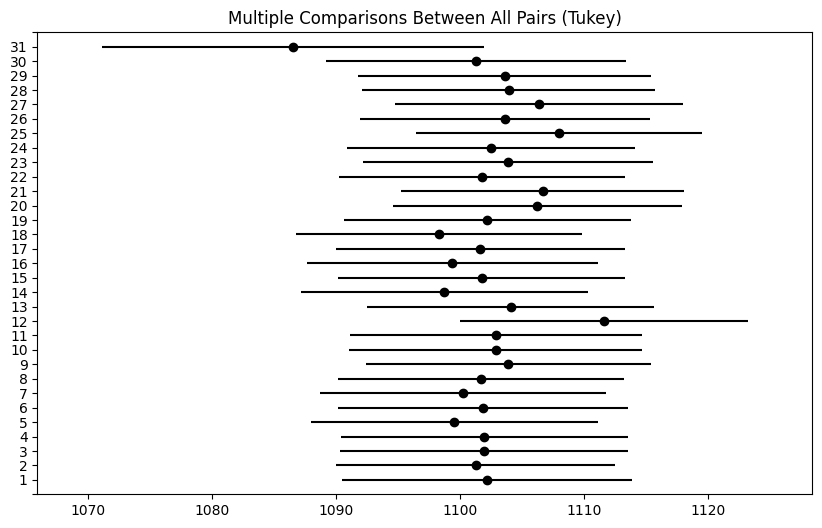

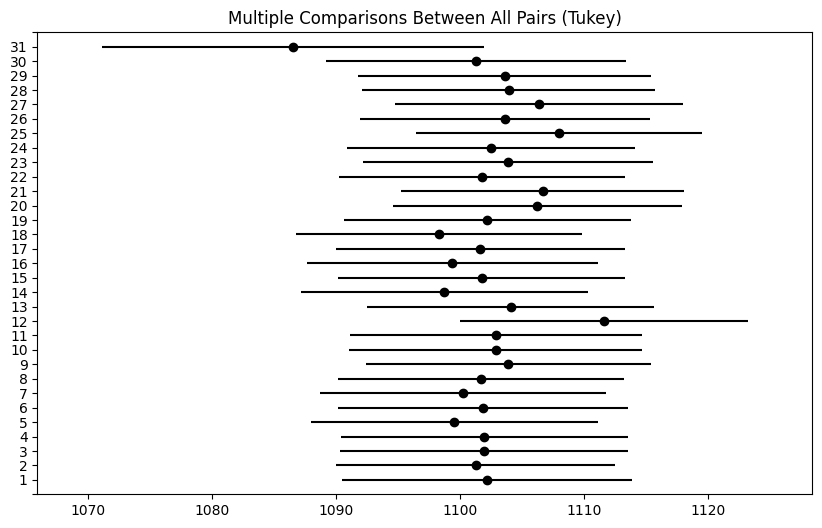

In [243]:
X['Day'] = X['Policy Start Date'].apply(lambda x: x.day)
result = pairwise_tukeyhsd(endog=X['y'], groups=X['Day'], alpha=0.05)
result.plot_simultaneous()

For now we will just keep year and month as date is a bit noisy

In [244]:
date_time = X.pop('Policy Start Date')

In [245]:
_ = X.pop('Day')

In [252]:
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['Policy Start Year'] = test['Policy Start Date'].apply(lambda x: x.year)
test['Month'] = test['Policy Start Date'].apply(lambda x: x.month)
test_date_time = test.pop('Policy Start Date')

# `get_dummies`: final data processing

In [140]:
y = X.pop('y')

In [250]:
X = pd.get_dummies(X)

In [253]:
test = pd.get_dummies(test)